# Read in data

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import numpy as np
from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
# import pyarrow as pa

In [2]:
"""
Disables RDKit whiny logging.
"""
import rdkit.rdBase as rkrb
import rdkit.RDLogger as rkl
logger = rkl.logger()
logger.setLevel(rkl.ERROR)
rkrb.DisableLog('rdApp.error')

In [3]:
# This is the data preprocessed in USPTO_preprocessing.ipynb
# There's around 500k reactions, and columns for reactant, product, solvent, reagent, etc.
# So there's quite a bit more data than in Modelling.ipynb

In [5]:
# read in pickled clean data
cleaned_df = pd.read_pickle(f"data/ORD_USPTO/cleaned_data.pkl")

In [6]:
# read in the reaction classes
rxn_classes_filename = 'data/ORD_USPTO/classified_rxn.smi'

with open(rxn_classes_filename) as f:
    lines = f.readlines()
lines = [line.rstrip('\n') for line in lines] # remove the \n at the end of each line

# create df of the reaction classes
# 2 columns: mapped_rxn, rxn_classes
rxns = []
rxn_classes = []
for line in lines:
    try:
        rxn, rxn_class = line.split(' ')
        rxns += [rxn]
        rxn_classes += [rxn_class]
    except AttributeError:
        continue
    
rxn_classes_df = pd.DataFrame(list(zip(rxns, rxn_classes)),
               columns =['mapped_rxn', 'rxn_class'])
    

In [7]:
# combine the two dfs
data_df_temp = cleaned_df.merge(rxn_classes_df, how='inner', left_on='mapped_rxn_0', right_on='mapped_rxn')
len(data_df_temp)

9

In [8]:
# I used the following command to generate the rxn classification:
# ./namerxn -nomap data/mapped_rxn.smi data/classified_rxn.smi

# The -nomap I thought would mean that it wouldn't change the atom mapping, yet it clearly did...
# I'll just have to trust that namerxn didn't change the order of my reactions, and just append the reaction classes, and finally remove any reactions that couldn't be classified
data_df = cleaned_df.copy().reset_index(drop=True)
data_df['rxn_class'] = rxn_classes_df['rxn_class']
data_df = data_df.dropna(subset=['rxn_class'])
data_df.reset_index()
print(len(data_df))

526999


In [9]:
# remove all the unclassified reactions, ie where rxn_class = '0.0'
remove_unclassified_rxn_data_df = data_df[~data_df.rxn_class.str.contains("0.0")]
print(len(remove_unclassified_rxn_data_df))

419295


# Manual cleaning

## Apply the cleaning that Alexander did

In [10]:
# print out all catalysts
#sorted(list(set(df['catalyst_0'].dropna())))

# initialize a dict that maps catalysts to the humanly cleaned smiles
catalyst_replacements = {}

catalyst_wrong = []
# All the data should have already been cleaned using rdkit.canonsmiles so I'm very surprised that there are some catalysts that are wrong. If you see any wrong catalysts, just remove them

In [11]:
# Add a catalyst to the catalyst_replacements dict
catalyst_replacements['CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+3].[Rh+3]'] = 'CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+2].[Rh+2]'
catalyst_replacements['[CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+3]]'] = 'CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].CC(=O)[O-].[Rh+2].[Rh+2]'
catalyst_replacements['[CC(C)(C)[P]([Pd][P](C(C)(C)C)(C(C)(C)C)C(C)(C)C)(C(C)(C)C)C(C)(C)C]'] = 'CC(C)(C)[PH]([Pd][PH](C(C)(C)C)(C(C)(C)C)C(C)(C)C)(C(C)(C)C)C(C)(C)C'
catalyst_replacements['CCCC[N+](CCCC)(CCCC)CCCC.CCCC[N+](CCCC)(CCCC)CCCC.CCCC[N+](CCCC)(CCCC)CCCC.[Br-].[Br-].[Br-]'] = 'CCCC[N+](CCCC)(CCCC)CCCC.[Br-]'
catalyst_replacements['[CCO.CCO.CCO.CCO.[Ti]]'] = 'CCO[Ti](OCC)(OCC)OCC'
catalyst_replacements['[CC[O-].CC[O-].CC[O-].CC[O-].[Ti+4]]'] = 'CCO[Ti](OCC)(OCC)OCC'
catalyst_replacements['[Cl[Ni]Cl.c1ccc(P(CCCP(c2ccccc2)c2ccccc2)c2ccccc2)cc1]'] = 'Cl[Ni]1(Cl)[P](c2ccccc2)(c2ccccc2)CCC[P]1(c1ccccc1)c1ccccc1'
catalyst_replacements['[Cl[Pd](Cl)([P](c1ccccc1)(c1ccccc1)c1ccccc1)[P](c1ccccc1)(c1ccccc1)c1ccccc1]'] = 'Cl[Pd](Cl)([PH](c1ccccc1)(c1ccccc1)c1ccccc1)[PH](c1ccccc1)(c1ccccc1)c1ccccc1'
catalyst_replacements['[Cl[Pd+2](Cl)(Cl)Cl.[Na+].[Na+]]'] = 'Cl[Pd]Cl'
catalyst_replacements['Karstedt catalyst'] = 'C[Si](C)(C=C)O[Si](C)(C)C=C.[Pt]'
catalyst_replacements["Karstedt's catalyst"] = 'C[Si](C)(C=C)O[Si](C)(C)C=C.[Pt]'
catalyst_replacements['[O=C([O-])[O-].[Ag+2]]'] = 'O=C([O-])[O-].[Ag+].[Ag+]'
catalyst_replacements['[O=S(=O)([O-])[O-].[Ag+2]]'] = 'O=S(=O)([O-])[O-].[Ag+].[Ag+]'
catalyst_replacements['[O=[Ag-]]'] = 'O=[Ag]'
catalyst_replacements['[O=[Cu-]]'] = 'O=[Cu]'
catalyst_replacements['[Pd on-carbon]'] = '[C].[Pd]'
catalyst_replacements['[TEA]'] = 'OCCN(CCO)CCO'
catalyst_replacements['[Ti-superoxide]'] = 'O=[O-].[Ti]'
catalyst_replacements['[[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1]'] = '[Pd].c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1.c1ccc(P(c2ccccc2)c2ccccc2)cc1'
catalyst_replacements['[c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd-4]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
catalyst_replacements['[c1ccc([P]([Pd][P](c2ccccc2)(c2ccccc2)c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
catalyst_replacements['[c1ccc([P](c2ccccc2)(c2ccccc2)[Pd]([P](c2ccccc2)(c2ccccc2)c2ccccc2)([P](c2ccccc2)(c2ccccc2)c2ccccc2)[P](c2ccccc2)(c2ccccc2)c2ccccc2)cc1]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
catalyst_replacements['[sulfated tin oxide]'] = 'O=S(O[Sn])(O[Sn])O[Sn]'
catalyst_replacements['[tereakis(triphenylphosphine)palladium(0)]'] = 'c1ccc([PH](c2ccccc2)(c2ccccc2)[Pd]([PH](c2ccccc2)(c2ccccc2)c2ccccc2)([PH](c2ccccc2)(c2ccccc2)c2ccccc2)[PH](c2ccccc2)(c2ccccc2)c2ccccc2)cc1'
catalyst_replacements['[zeolite]'] = 'O=[Al]O[Al]=O.O=[Si]=O'

In [12]:
# add any wrong catalysts you spot, e.g.
catalyst_wrong += ['Catalyst A',
'catalyst',
'catalyst 1',
'catalyst A',
'catalyst VI',
'reaction mixture',
'same catalyst',
'solution']


In [13]:
# drop all rows that contain a 'catalyst_wrong
df2 = data_df[~data_df["catalyst_0"].isin(catalyst_wrong)]

In [14]:
# do the catalyst replacements that Alexander found
df3 = df2.replace(catalyst_replacements)

In [15]:
df3.reset_index(inplace=True)

In [16]:
count = 0
for i in range(len(data_df['reagents_0'])):
    r = data_df['reagents_0'][i]
    if r ==r:
        if 'pd' in r or 'Pd' in r or 'palladium' in r or 'Palladium' in r:
            count +=1
print('Number of Pd in the reagents columns: ', count )

Number of Pd in the reagents columns:  1205


In [17]:
# Quite a few of the rows have Pd as a reagent. Probably worth going through all of them, and if the value in reagent_0 is already in catalyst_0, then replace the reagent value with np.NaN
df3["reagents_0"] = df3.apply(lambda x: np.nan if (pd.notna(x["reagents_0"]) and pd.notna(x["catalyst_0"]) and x["reagents_0"] in x["catalyst_0"]) else x["reagents_0"], axis=1)
df3["reagents_1"] = df3.apply(lambda x: np.nan if (pd.notna(x["reagents_1"]) and pd.notna(x["catalyst_0"]) and x["reagents_1"] in x["catalyst_0"]) else x["reagents_1"], axis=1)


In [18]:
# That took care of a majority of the cases! Now there are only 9+7 cases left, just drop these rows
df3 = df3[df3["reagents_0"] != '[Pd]']
df3 = df3[df3["reagents_0"] != '[Pd+2]']
df3 = df3[df3["reagents_1"] != '[Pd]']
df3 = df3[df3["reagents_1"] != '[Pd+2]']
df3 = df3.reset_index(drop=True)



In [26]:
df3.columns

Index(['index', 'mapped_rxn_0', 'reactant_0', 'reactant_1', 'reactant_2',
       'reactant_3', 'reagents_0', 'reagents_1', 'solvent_0', 'solvent_1',
       'catalyst_0', 'temperature_0', 'rxn_time_0', 'rxn_time_1', 'product_0',
       'product_1', 'product_2', 'product_3', 'yields_0', 'yields_1',
       'yields_2', 'yields_3', 'rxn_class', 'rxn_super_class'],
      dtype='object')

In [32]:
df3['rxn_class']

0                11.6
1               9.1.5
2               7.9.1
3               7.9.1
4              1.7.12
             ...     
526797          1.7.9
526798    1.6.2;6.3.9
526799          1.2.2
526800    2.2.3;6.3.9
526801          2.2.3
Name: rxn_class, Length: 526802, dtype: object

In [33]:
df3['rxn_super_class']

0         11
1          9
2          7
3          7
4          1
          ..
526797     1
526798     1
526799     1
526800     2
526801     2
Name: rxn_super_class, Length: 526802, dtype: int32

In [19]:
count = 0
for i in range(len(df3['reagents_1'])):
    r = df3['reagents_1'][i]
    if r ==r:
        if 'Pd' in r:
            print(r)
            count +=1
print('Number of Pd in the reagents columns: ', count )

Number of Pd in the reagents columns:  0


In [20]:
len(df3)

526802

## Add a cluster column

In [21]:
df3['rxn_super_class'] = df3['rxn_class'].str.rsplit('.', expand=True)[0].astype(int)
test_df = df3['rxn_class'].str.rsplit(';', expand=True)
# 2.5% of reactions have been assigned 2 reaction classes. 3 or 4 reaction classes is very rare.

# Prepare fingerprints

In [22]:
from modelling_3 import calc_fp
from modelling_3 import calc_fp_individual
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
from rdkit.rdBase import BlockLogs
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem

In [23]:
%%time
num_cores = multiprocessing.cpu_count()
inputs = tqdm(df3['product_0'])
p0 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['product_1'])
p1 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['product_2'])
p2 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['product_3'])
p3 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

100%|██████████| 526802/526802 [00:12<00:00, 41258.04it/s]


Wall time: 1min 12s


In [24]:
%%time
num_cores = multiprocessing.cpu_count()
inputs = tqdm(df3['reactant_0'])
r0 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['reactant_1'])
r1 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['reactant_2'])
r2 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

inputs = tqdm(df3['reactant_3'])
r3 = Parallel(n_jobs=num_cores)(delayed(calc_fp_individual)(i) for i in inputs)

 62%|██████▏   | 327664/526802 [00:10<00:05, 37538.64it/s]

MemoryError: 

 62%|██████▏   | 327664/526802 [00:26<00:05, 37538.64it/s]

In [ ]:
# calculate rxn difference fp
# converting one 500k by 2k list to array takes roughly 15s, so the whole thing should take about 2-3 min
# need to split into different cells for memory purposes
ar_p0 = np.array(p0)
ar_p1 = np.array(p1)
ar_p2 = np.array(p2)
ar_p3 = np.array(p3)
ar_r0 = np.array(r0)
ar_r1 = np.array(r1)
ar_r2 = np.array(r2)
ar_r3 = np.array(r3)

In [ ]:
product_fp = ar_p0 + ar_p1 + ar_p2 + ar_p3
product_fp.shape

(526802, 2048)

In [ ]:
rxn_diff_fp = product_fp - ar_r0 - ar_r1 - ar_r2 - ar_r3
rxn_diff_fp.shape

(526802, 2048)

In [30]:
#save to pickle
# np.save("data/ORD_USPTO/USPTO_rxn_diff_fp.pkl", rxn_diff_fp)
# np.save("data/ORD_USPTO/USPTO_product_fp.pkl", product_fp)

# NN modelling

In [ ]:
import torch
import torch.nn as nn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import Accuracy

/Users/dsw46/opt/anaconda3/envs/chemistry/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gao model

In [22]:
# https://pubs.acs.org/doi/full/10.1021/acscentsci.8b00357

In [23]:
#unpickle
# rxn_diff_fp = np.load("data/ORD_USPTO/USPTO_rxn_diff_fp.pkl.npy", allow_pickle=True)
# product_fp = np.load("data/ORD_USPTO/USPTO_product_fp.pkl.npy", allow_pickle=True)
# Run all cells in the "Read in data" section to get data_df

# find the data in df3

In [ ]:
rxn_diff_fp.shape == product_fp.shape

True

In [ ]:
# prepare input for model
np_input = np.concatenate((product_fp, rxn_diff_fp), axis=1)

X = torch.from_numpy(np_input).float()

# prepare output for model
enc = OneHotEncoder()
catalyst_encoded = enc.fit_transform(df3[['catalyst_0']])
solvent_encoded = enc.fit_transform(df3[['solvent_0']])

catalyst_encoded = catalyst_encoded.toarray()
solvent_encoded = solvent_encoded.toarray()

y_catalyst = torch.from_numpy(catalyst_encoded)
y_solvent = torch.from_numpy(solvent_encoded)


In [ ]:
# Split the data into train and test sets

X_train, X_test, y_catalyst_train, y_catalyst_test, y_solvent_train, y_solvent_test = train_test_split(X, y_catalyst, y_solvent, test_size=0.2, random_state=42)


In [ ]:
X_train.shape

torch.Size([421441, 4096])

In [ ]:
X_test.shape

torch.Size([105361, 4096])

In [ ]:
# use torch.nn
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        # Architecture
        self.input_layer = nn.Linear(X_train.shape[1], 1000)
        
        self.linear1000_1000 = nn.Linear(1000, 1000)
        self.linear1000_500 = nn.Linear(1000, 500)
        self.linear1000_300 = nn.Linear(1000, 300)
        self.linear600_300 = nn.Linear(600, 300)
        self.linear500_300 = nn.Linear(500, 300)
        self.linear300_300 = nn.Linear(300, 300)
        
        # Catalyst_0 output layer
        self.catalyst_output = nn.Linear(300, len(df3['catalyst_0'].unique()))
        
        
        # Solvent_0 output layer
        self.solvent_input = nn.Linear(len(df3['catalyst_0'].unique()), 100)

        self.solvent_output = nn.Linear(300, len(df3['solvent_0'].unique()))
        
        # Activation functions and dropout softmax (stuff with parameters)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim = 1)
        
        
    def forward(self, x):
        x = self.input_layer(x)
        x = self.relu(x)
        x = self.linear1000_1000(x)
        x = self.relu(x)
        cat_latent_1 = self.dropout(x)
        x = self.linear1000_300(cat_latent_1)
        x = self.relu(x)
        x = self.linear300_300(x)
        x = self.tanh(x)
        
        # Catalyst_0 output
        catalyst_out = self.catalyst_output(x)
        catalyst_out = self.softmax(catalyst_out)
        
        # Solvent_0 output
        solvent_input = self.solvent_input(catalyst_out)
        x = self.relu(solvent_input)
        cat_latent_2 = self.linear1000_500(cat_latent_1)
        x = torch.cat((x, cat_latent_2), 1)
        x = self.linear600_300(x)
        x = self.relu(x)
        x = self.linear300_300(x)
        x = self.tanh(x)
        solvent_out = self.solvent_output(x)
        solvent_out = self.softmax(solvent_out)
        
        return catalyst_out, solvent_out


In [ ]:
model = NeuralNet()
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the number of training iterations
num_epochs = 100

In [ ]:
def top_k_accuracy(k, predicted, actual):
    accuracy = Accuracy(task="multiclass", num_classes=len(predicted[1]), top_k=k)
    acc = accuracy(predicted, torch.argmax(actual, dim=1))
    return acc

In [ ]:
# Initialize lists to store the train and test loss
train_loss = []
test_loss = []

top_1_cat_train = []
top_3_cat_train = []
top_1_solv_train = []
top_3_solv_train = []

top_1_cat_test = []
top_3_cat_test = []
top_1_solv_test = []
top_3_solv_test = []

# Define the batch size
batch_size = 16384
num_batches = len(X_train) // batch_size

# Create data loaders for the training data
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_catalyst_train, y_solvent_train),
    batch_size=batch_size,
    shuffle=True
)

# Create data loader for test data
test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_test, y_catalyst_test, y_solvent_test),
    batch_size=batch_size,
    shuffle=False
)


# Training the model
for epoch in range(num_epochs):
    train_loss_batch = []
    
    top_1_cat_train_batch = []
    top_3_cat_train_batch = []
    
    top_1_solv_train_batch = []
    top_3_solv_train_batch = []
    
    for X_batch, y_catalyst_batch, y_solvent_batch in tqdm(train_loader):
        # Forward pass
        catalyst_out, solvent_out = model(X_batch)
        
        # Compute the train loss
        loss_catalyst = criterion(catalyst_out, y_catalyst_batch)
        loss_solvent = criterion(solvent_out, y_solvent_batch)
        loss = loss_catalyst + loss_solvent
        train_loss_batch.append(loss.item())
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Backward pass
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Compute accuracy for catalyst
        top_1_cat_train_batch += [top_k_accuracy(1, catalyst_out, y_catalyst_batch)]
        top_3_cat_train_batch += [top_k_accuracy(3, catalyst_out, y_catalyst_batch)]
        
        # Compute accuracy for solvent
        top_1_solv_train_batch += [top_k_accuracy(1, solvent_out, y_solvent_batch)]
        top_3_solv_train_batch += [top_k_accuracy(3, solvent_out, y_solvent_batch)]
    
    train_loss += [np.mean(train_loss_batch)]
        
    top_1_cat_train += [np.mean(top_1_cat_train_batch)]
    top_3_cat_train += [np.mean(top_3_cat_train_batch)]
    
    top_1_solv_train += [np.mean(top_1_cat_train_batch)]
    top_3_solv_train += [np.mean(top_3_cat_train_batch)]
        
        
    # Compute the test loss
    with torch.no_grad():
        top_1_cat_test_batch = []
        top_3_cat_test_batch = []
        
        top_1_solv_test_batch = []
        top_3_solv_test_batch = []
        
        test_loss_batch = []
        
        for X_batch, y_catalyst_batch, y_solvent_batch in test_loader:
            catalyst_out, solvent_out = model(X_batch)
            loss_catalyst = criterion(catalyst_out, y_catalyst_batch)
            loss_solvent = criterion(solvent_out, y_solvent_batch)
            loss = loss_catalyst + loss_solvent
            test_loss_batch.append(loss.item())
            
            # Compute accuracy for catalyst
            top_1_cat_test_batch += [top_k_accuracy(1, catalyst_out, y_catalyst_batch)]
            top_3_cat_test_batch += [top_k_accuracy(3, catalyst_out, y_catalyst_batch)]
            
            # Compute accuracy for solvent
            top_1_solv_test_batch += [top_k_accuracy(1, solvent_out, y_solvent_batch)]
            top_3_solv_test_batch += [top_k_accuracy(3, solvent_out, y_solvent_batch)]
        
        top_1_cat_test += [np.mean(top_1_cat_test_batch)]
        top_3_cat_test += [np.mean(top_3_cat_test_batch)]
        
        top_1_solv_test += [np.mean(top_1_solv_test_batch)]
        top_3_solv_test += [np.mean(top_3_solv_test_batch)]
        test_loss += [np.mean(test_loss_batch)]
            
    # Print train loss and accuracy
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss[-1]))
    print('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, num_epochs, test_loss[-1]))


100%|██████████| 26/26 [01:59<00:00,  4.60s/it]


Epoch [1/100], Train Loss: 10.9742
Epoch [1/100], Test Loss: 10.7393


100%|██████████| 26/26 [01:54<00:00,  4.40s/it]


Epoch [2/100], Train Loss: 10.7407
Epoch [2/100], Test Loss: 10.7391


100%|██████████| 26/26 [01:39<00:00,  3.83s/it]


Epoch [3/100], Train Loss: 10.7406
Epoch [3/100], Test Loss: 10.7390


100%|██████████| 26/26 [02:10<00:00,  5.01s/it]


Epoch [4/100], Train Loss: 10.7407
Epoch [4/100], Test Loss: 10.7390


100%|██████████| 26/26 [02:09<00:00,  5.00s/it]


Epoch [5/100], Train Loss: 10.7406
Epoch [5/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:36<00:00,  3.71s/it]


Epoch [6/100], Train Loss: 10.7405
Epoch [6/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:30<00:00,  3.48s/it]


Epoch [7/100], Train Loss: 10.7405
Epoch [7/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [8/100], Train Loss: 10.7406
Epoch [8/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


Epoch [9/100], Train Loss: 10.7406
Epoch [9/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:30<00:00,  3.49s/it]


Epoch [10/100], Train Loss: 10.7406
Epoch [10/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:30<00:00,  3.47s/it]


Epoch [11/100], Train Loss: 10.7405
Epoch [11/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


Epoch [12/100], Train Loss: 10.7406
Epoch [12/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.40s/it]


Epoch [13/100], Train Loss: 10.7406
Epoch [13/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.40s/it]


Epoch [14/100], Train Loss: 10.7406
Epoch [14/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:30<00:00,  3.49s/it]


Epoch [15/100], Train Loss: 10.7406
Epoch [15/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [16/100], Train Loss: 10.7406
Epoch [16/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [17/100], Train Loss: 10.7405
Epoch [17/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [18/100], Train Loss: 10.7406
Epoch [18/100], Test Loss: 10.7390


100%|██████████| 26/26 [01:28<00:00,  3.39s/it]


Epoch [19/100], Train Loss: 10.7405
Epoch [19/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [20/100], Train Loss: 10.7406
Epoch [20/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.45s/it]


Epoch [21/100], Train Loss: 10.7406
Epoch [21/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


Epoch [22/100], Train Loss: 10.7405
Epoch [22/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [23/100], Train Loss: 10.7405
Epoch [23/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.47s/it]


Epoch [24/100], Train Loss: 10.7405
Epoch [24/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [25/100], Train Loss: 10.7405
Epoch [25/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


Epoch [26/100], Train Loss: 10.7405
Epoch [26/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.45s/it]


Epoch [27/100], Train Loss: 10.7405
Epoch [27/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.53s/it]


Epoch [28/100], Train Loss: 10.7405
Epoch [28/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.51s/it]


Epoch [29/100], Train Loss: 10.7406
Epoch [29/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.45s/it]


Epoch [30/100], Train Loss: 10.7406
Epoch [30/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [31/100], Train Loss: 10.7406
Epoch [31/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.47s/it]


Epoch [32/100], Train Loss: 10.7405
Epoch [32/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.48s/it]


Epoch [33/100], Train Loss: 10.7405
Epoch [33/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.53s/it]


Epoch [34/100], Train Loss: 10.7404
Epoch [34/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [35/100], Train Loss: 10.7405
Epoch [35/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [36/100], Train Loss: 10.7405
Epoch [36/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [37/100], Train Loss: 10.7404
Epoch [37/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.43s/it]


Epoch [38/100], Train Loss: 10.7405
Epoch [38/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.49s/it]


Epoch [39/100], Train Loss: 10.7405
Epoch [39/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.48s/it]


Epoch [40/100], Train Loss: 10.7405
Epoch [40/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.49s/it]


Epoch [41/100], Train Loss: 10.7406
Epoch [41/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.52s/it]


Epoch [42/100], Train Loss: 10.7405
Epoch [42/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.47s/it]


Epoch [43/100], Train Loss: 10.7405
Epoch [43/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.46s/it]


Epoch [44/100], Train Loss: 10.7405
Epoch [44/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.43s/it]


Epoch [45/100], Train Loss: 10.7405
Epoch [45/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [46/100], Train Loss: 10.7406
Epoch [46/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.43s/it]


Epoch [47/100], Train Loss: 10.7404
Epoch [47/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:30<00:00,  3.47s/it]


Epoch [48/100], Train Loss: 10.7405
Epoch [48/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.44s/it]


Epoch [49/100], Train Loss: 10.7405
Epoch [49/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.51s/it]


Epoch [50/100], Train Loss: 10.7405
Epoch [50/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.42s/it]


Epoch [51/100], Train Loss: 10.7405
Epoch [51/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:31<00:00,  3.53s/it]


Epoch [52/100], Train Loss: 10.7404
Epoch [52/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.45s/it]


Epoch [53/100], Train Loss: 10.7405
Epoch [53/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:29<00:00,  3.43s/it]


Epoch [54/100], Train Loss: 10.7406
Epoch [54/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:28<00:00,  3.41s/it]


Epoch [55/100], Train Loss: 10.7406
Epoch [55/100], Test Loss: 10.7389


100%|██████████| 26/26 [01:32<00:00,  3.58s/it]


Epoch [56/100], Train Loss: 10.7405
Epoch [56/100], Test Loss: 10.7389


 81%|████████  | 21/26 [02:25<00:34,  6.92s/it]


KeyboardInterrupt: 

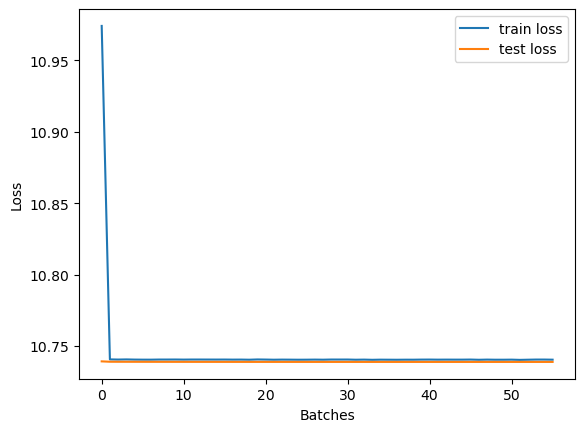

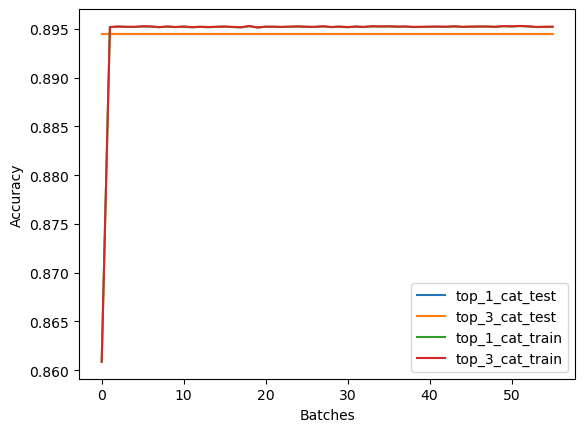

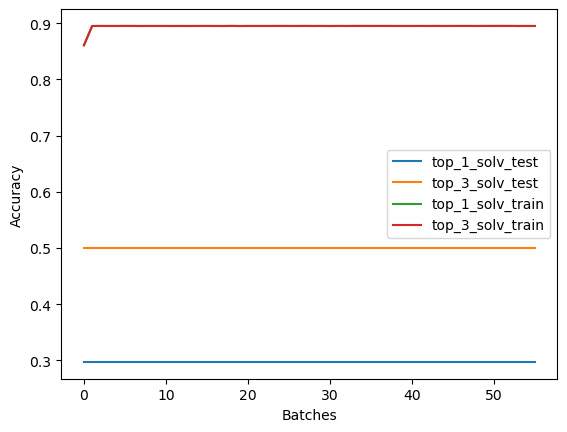

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the train and test loss
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

# Plot the train and test accuracy
# Catalyst
plt.plot(top_1_cat_test, label='top_1_cat_test')
plt.plot(top_3_cat_test, label='top_3_cat_test')
plt.plot(top_1_cat_train, label='top_1_cat_train')
plt.plot(top_3_cat_train, label='top_3_cat_train')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.clf()

# Plot the train and test accuracy
# Solvent
plt.plot(top_1_solv_test, label='top_1_solv_test')
plt.plot(top_3_solv_test, label='top_3_solv_test')
plt.plot(top_1_solv_train, label='top_1_solv_train')
plt.plot(top_3_solv_train, label='top_3_solv_train')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.clf()




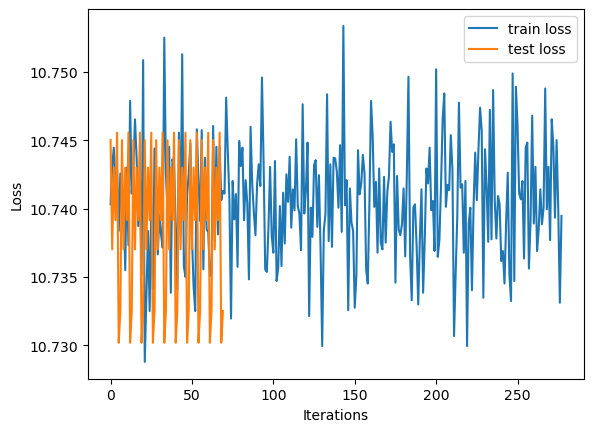

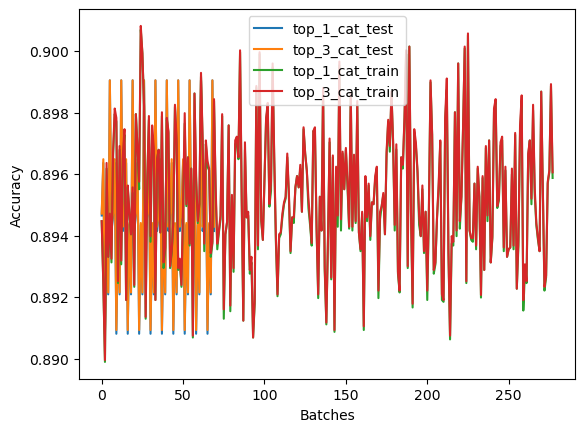

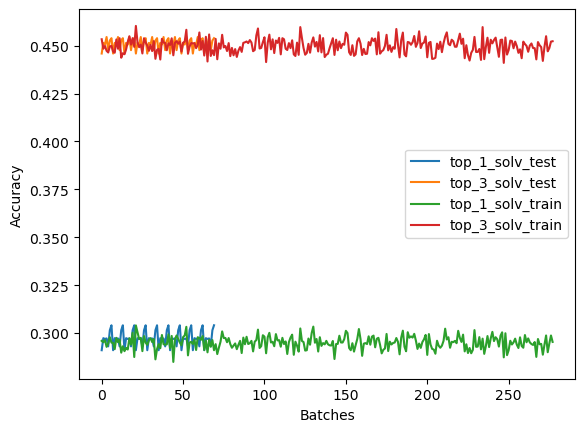

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot the train and test loss
plt.plot(train_loss, label='train loss')
plt.plot(test_loss, label='test loss')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

# Plot the train and test accuracy
# Catalyst
plt.plot(top_1_cat_test, label='top_1_cat_test')
plt.plot(top_3_cat_test, label='top_3_cat_test')
plt.plot(top_1_cat_train, label='top_1_cat_train')
plt.plot(top_3_cat_train, label='top_3_cat_train')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.clf()

# Plot the train and test accuracy
# Solvent
plt.plot(top_1_solv_test, label='top_1_solv_test')
plt.plot(top_3_solv_test, label='top_3_solv_test')
plt.plot(top_1_solv_train, label='top_1_solv_train')
plt.plot(top_3_solv_train, label='top_3_solv_train')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.clf()




## Other models

In [9]:
import torch
import torchmetrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tqdm import trange

from modelling_3 import FullyConnectedReactionModel
from modelling_3 import train_loop

e=70
batch_size=0.07
lr=1e-4


/Users/dsw46/opt/anaconda3/envs/chemistry/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
#unpickle
rxn_diff_fp = np.load("data/ORD_USPTO/USPTO_rxn_diff_fp.pkl.npy", allow_pickle=True)
# Run all cells in the "Read in data" section to get data_df

In [29]:
rxn_diff_fp.shape

(526999, 2048)

In [12]:
data_df.columns

Index(['mapped_rxn_0', 'reactant_0', 'reactant_1', 'reactant_2', 'reactant_3',
       'reagents_0', 'reagents_1', 'solvent_0', 'solvent_1', 'catalyst_0',
       'temperature_0', 'rxn_time_0', 'rxn_time_1', 'product_0', 'product_1',
       'product_2', 'product_3', 'yields_0', 'yields_1', 'yields_2',
       'yields_3', 'rxn_class'],
      dtype='object')

In [13]:
len(data_df)

526999

In [14]:
# prep the data
cat = np.array(data_df['catalyst_0'])
# Do the one-hot encoding
enc = OneHotEncoder(handle_unknown='ignore')
cat_reshaped = cat.reshape(-1, 1)
_ = enc.fit(cat_reshaped)

cat_ohe = enc.transform(cat.reshape(-1, 1)).toarray()

rxn_diff_fp_train, rxn_diff_fp_val, cat_ohe_train, cat_ohe_val = train_test_split(rxn_diff_fp, cat_ohe, test_size=0.2, random_state=42)

## Big NN (full sharing)

In [15]:
# A data through one model for all reactions
# rxn_diff_fp width -> ohe width

x_train = torch.Tensor(rxn_diff_fp_train)
y_train = torch.Tensor(cat_ohe_train)
x_val = torch.Tensor(rxn_diff_fp_val)
y_val = torch.Tensor(cat_ohe_val)
fcrm = FullyConnectedReactionModel(
    input_dim=x_train.shape[1],
    hidden_dims=[600, 600],
    target_dim=y_train.shape[1],
    hidden_act=torch.nn.ReLU, 
    output_act=torch.nn.Identity, 
    use_batchnorm=True, 
    dropout_prob=0.2,
)

optimizer = torch.optim.Adam(fcrm.parameters(), lr=lr)
scheduler = None  # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
early_stopper = None  # EarlyStopper(patience=50, min_delta=0, verbose=True)

hist = train_loop(fcrm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=optimizer, report_freq=1, x_val=x_val, y_val=y_val, scheduler=scheduler, early_stopper=early_stopper)

Epoch: 69 Train [ Loss: 0.15031 | Acc (Top 1): 0.96769 | Acc (Top 3): 0.98997 | Acc (Top 5): 0.99344]	 Validation [ Loss: 0.81797 | Acc (Top 1): 0.92578 | Acc (Top 3): 0.96625 | Acc (Top 5):  0.97294]: 100%|██████████| 70/70 [58:29<00:00, 50.14s/it]


NameError: name 'pd' is not defined

NameError: name 'hist' is not defined

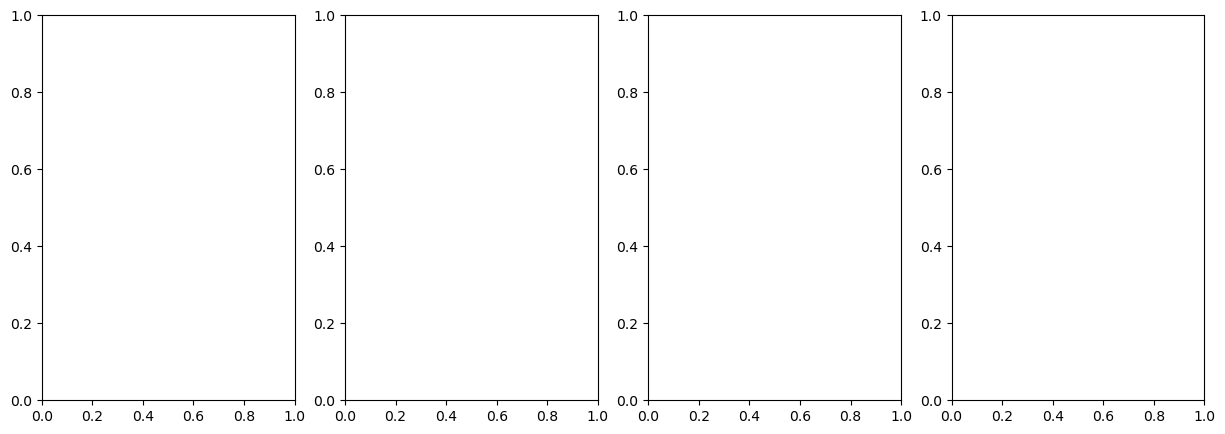

In [20]:
f,ax=plt.subplots(1,4, figsize=(15, 5))
hist.loc[:, (slice(None), "loss")].droplevel(level=1,axis=1).plot(title="Cross Entropy (Loss)", ax=ax[0])
hist.loc[:, (slice(None), "acc")].droplevel(level=1,axis=1).plot(title="Accuracy", ax=ax[1])
hist.loc[:, (slice(None), "acc_top3")].droplevel(level=1,axis=1).plot(title="Top 3 Accuracy", ax=ax[2])
hist.loc[:, (slice(None), "acc_top5")].droplevel(level=1,axis=1).plot(title="Top 5 Accuracy", ax=ax[3])
f.suptitle("All Data")

## 1 model per cluster

In [22]:
# Data through one model per reaction cluster
# rxn_diff_fp width -> ohe width

train_clusters = Kmean.predict(rxn_diff_fp_train)
val_clusters = Kmean.predict(rxn_diff_fp_val)

cluster_models = {}
cluster_histories = {}

for cluster in np.unique(train_clusters):
    print(cluster)
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    y_train = torch.Tensor(reag1_ohe_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    y_val = torch.Tensor(reag1_ohe_val[val_clusters == cluster])
    fcrm = FullyConnectedReactionModel(
        input_dim=x_train.shape[1],
        hidden_dims=[600,600],
        target_dim=y_train.shape[1],
        hidden_act=torch.nn.ReLU, 
        output_act=torch.nn.Identity, 
        use_batchnorm=True, 
        dropout_prob=0.2,
    )

    optimizer=torch.optim.Adam(fcrm.parameters(), lr=lr)
    scheduler = None#torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)
    early_stopper = None#EarlyStopper(patience=50, min_delta=0, verbose=True)

    hist = train_loop(fcrm, x_train, y_train, epochs=e, batch_size=batch_size, loss_fn=torch.nn.CrossEntropyLoss(), optimizer=optimizer, report_freq=1, x_val=x_val, y_val=y_val, scheduler=scheduler, early_stopper=early_stopper)
    cluster_models[cluster] = fcrm
    cluster_histories[cluster] = hist

NameError: name 'Kmean' is not defined

In [ ]:
y_train = torch.Tensor(reag1_ohe_train)
y_val = torch.Tensor(reag1_ohe_val)
pred_train = torch.zeros_like(y_train)
pred_val = torch.zeros_like(y_val)
for cluster in np.unique(train_clusters):
    x_train = torch.Tensor(rxn_diff_fp_train[train_clusters == cluster])
    x_val = torch.Tensor(rxn_diff_fp_val[val_clusters == cluster])
    cluster_pred_train = cluster_models[cluster](x_train, training=False)
    cluster_pred_val = cluster_models[cluster](x_val, training=False)
    pred_train[train_clusters == cluster] = cluster_pred_train
    pred_val[val_clusters == cluster] = cluster_pred_val

acc_metric_top1 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=1)
acc_metric_top3 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=3)
acc_metric_top5 = torchmetrics.Accuracy(task="multiclass", num_classes=y_train.shape[1], top_k=5)

train_acc, train_acc_top3, train_acc_top5 = acc_metric_top1(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top3(pred_train, y_train.argmax(axis=1)).item(), acc_metric_top5(pred_train, y_train.argmax(axis=1)).item()
val_acc, val_acc_top3, val_acc_top5 = acc_metric_top1(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top3(pred_val, y_val.argmax(axis=1)).item(), acc_metric_top5(pred_val, y_val.argmax(axis=1)).item()

print(f"Train      [ Acc (Top 1): {train_acc:.5f} | Acc (Top 3): {train_acc_top3:.5f} | Acc (Top 5): {train_acc_top5: .5f}]")
print(f"Validation [ Acc (Top 1): {val_acc:.5f} | Acc (Top 3): {val_acc_top3:.5f} | Acc (Top 5): {val_acc_top5: .5f}]")